# An hour blitz to practical thermodynamics

### Pure component chemical models

Thermosteam packages chemical and mixture thermodynamic models in a flexible framework that allows users to fully customize and extend the models, as well as create new models. Central to all thermodynamic algorithms is the [Chemical](../Chemical.txt) object, which contains constant chemical properties, as well as thermodynamic and transport properties as a function of temperature and pressure:

In [1]:
import thermosteam as tmo
# Initialize chemical with an identifier (e.g. by name, CAS, InChI...)
Water = tmo.Chemical('Water') 
Water

Chemical: Water (phase_ref='l')
[Names]  CAS: 7732-18-5
         InChI: H2O/h1H2
         InChI_key: XLYOFNOQVPJJNP-U...
         common_name: water
         iupac_name: ('oxidane',)
         pubchemid: 962
         smiles: O
         formula: H2O
[Groups] Dortmund: <1H2O>
         UNIFAC: <1H2O>
         PSRK: <1H2O>
[Data]   MW: 18.015 g/mol
         Tm: 273.15 K
         Tb: 373.12 K
         Tt: 273.15 K
         Tc: 647.14 K
         Pt: 610.88 Pa
         Pc: 2.2048e+07 Pa
         Vc: 5.6e-05 m^3/mol
         Hf: -2.8582e+05 J/mol
         LHV: 44011 J/mol
         HHV: 0 J/mol
         Hfus: 6010 J/mol
         omega: 0.344
         dipole: 1.85 Debye
         similarity_variable: 0.16653
         iscyclic_aliphatic: 0
         combustion: {}


All fields can be easility accessed, for example:

In [2]:
# CAS number
Water.CAS

'7732-18-5'

In [3]:
# Molecular weight (g/mol)
Water.MW

18.01528

In [4]:
# Boiling point (K)
Water.Tb

373.124

Temperature (in Kelvin) and pressure (in Pascal) dependent properties can be computed:

In [5]:
# Vapor pressure (Pa)
Water.Psat(T=373.15)

101284.55179999319

In [6]:
# Surface tension (N/m)
Water.sigma(T=298.15)

0.07205503890847455

In [7]:
# Liquid molar volume (m^3/mol)
Water.V(phase='l', T=298.15, P=101325)

1.806920448788909e-05

In [8]:
# Vapor molar volume (m^3/mol)
Water.V(phase='g', T=298.15, P=101325)

0.023505766772305356

Temperature dependent properties are managed by indexable model handles, which contain many models ordered in decreasing priority:

In [9]:
Water.Psat

TDependentModelHandle(T, P=None) -> Psat [Pa]
[0] Wagner McGraw
[1] Antoine
[2] DIPPR EQ101
[3] Wagner
[4] Boiling Critical Relation
[5] Lee Kesler
[6] Ambrose Walton
[7] Sanjari
[8] Edalat


Each model is applicable to a certain domain, as given by their `Tmin` and `Tmax`:

In [10]:
Wagner_McGraw = Water.Psat[0]
Wagner_McGraw

TDependentModel(T, P=None) -> Psat [Pa]
 name: Wagner McGraw
 Tmin: 275 K
 Tmax: 647.35 K


In [11]:
# Note that these attributes can be get/set too
Wagner_McGraw.Tmax, Wagner_McGraw.Tmin

(647.35, 275)

When called, the model handle searches through each model until it finds one with an applicable domain. If none are applicable, a domain error is raised:

In [12]:
Water.Psat(1000.0)

DomainError: Water (CAS: 7732-18-5) has no valid saturated vapor pressure model at T=1000.00 K

Model handles as well as the models themselves have tabulation and plotting methods to help visualize how properties depend on temperature and pressure.

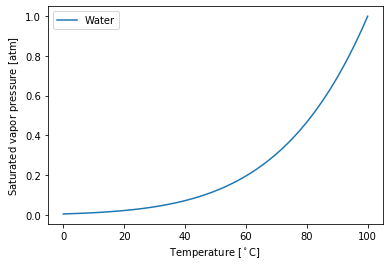

In [13]:
Water.Psat.plot_vs_T([Water.Tm, Water.Tb], 'degC', 'atm', label="Water")   

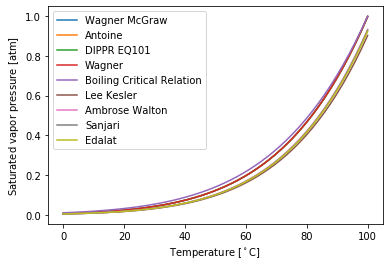

In [14]:
# Plot all models
Water.Psat.plot_models_vs_T([Water.Tm, Water.Tb], 'degC', 'atm')

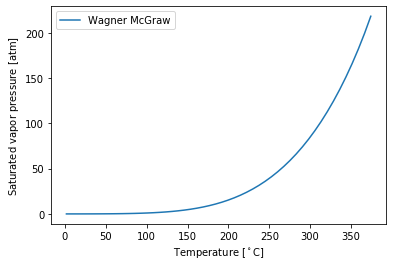

In [15]:
# Plot only the 'Wagner McGraw model'
Water.Psat[0].plot_vs_T(T_units='degC', units='atm') # Bounds are the model's Tmin and Tmax

Manage the model order with the `set_model_priority` and `move_up_model_priority` methods:

In [16]:
# Note: In this case, we pass the model name, but its
# also possible to pass the current index, or the model itself.
Water.Psat.move_up_model_priority('Antoine')
Water.Psat[0] # Notice how Antoine is now in the top priority

TDependentModel(T, P=None) -> Psat [Pa]
 name: Antoine
 Tmin: 273.2 K
 Tmax: 473.2 K


In [17]:
Water.Psat.set_model_priority('Wagner McGraw')
Water.Psat[0] # Notice how Wagner_McGraw is back on top priority

TDependentModel(T, P=None) -> Psat [Pa]
 name: Wagner McGraw
 Tmin: 275 K
 Tmax: 647.35 K


When setting a model priority, the default priority is `0` (or top priority), but you can choose any priority:

In [18]:
Water.Psat.set_model_priority('Antoine', 2)
Water.Psat[2] # Moved Antoine to priority #2

TDependentModel(T, P=None) -> Psat [Pa]
 name: Antoine
 Tmin: 273.2 K
 Tmax: 473.2 K


Thermodynamic properties dependent on the phase are handled by phase properties:

In [19]:
Water.V

<PhaseTPHandle(phase, T, P) -> V [m^3/mol]>

Phase properties contain model handles as attributes:

In [20]:
Water.V.l

TPDependentModelHandle(T, P) -> V.l [m^3/mol]
[0] VDI PPDS
[1] Campbell Thodos
[2] Yen Woods
[3] Rackett
[4] Yamada Gunn
[5] Bhirud Normal
[6] Townsend Hales
[7] CRC inorganic liquid constant
[8] Rackett
[9] Costald
[10] Costald Compressed


In [21]:
Water.V.g

TPDependentModelHandle(T, P) -> V.g [m^3/mol]
[0] Tsonopoulos extended
[1] Tsonopoulos
[2] Abbott
[3] Pitzer Curl
[4] CRCVirial
[5] ideal gas


A new model can be added easily to a model handle through the `add_model` method, for example:

In [22]:
# Set top_priority=True to place model in postion [0]
@Water.Psat.add_model(Tmin=273.20, Tmax=473.20, top_priority=True)
def User_antoine_model(T):
     return 10.0**(10.116 -  1687.537 / (T - 42.98))
Water.Psat[0]

TDependentModel(T) -> Psat [Pa]
 name: User antoine model
 Tmin: 273.2 K
 Tmax: 473.2 K


The `add_model` method is a high level interface that even lets you create a constant model:

In [23]:
Water.V.l.add_model(1.687e-05, name='User constant')
# Model is appended at the end by default
Water.V.l[-1]

ConstantThermoModel(T=None, P=None) -> V.l [m^3/mol]
 name: User constant
 value: 1.687e-05
 Tmin: 0 K
 Tmax: inf K
 Pmin: 0 Pa
 Pmax: inf Pa


Lastly, all default models in thermosteam have functors (i.e. functions with adjustable parameters):

In [24]:
# The saturated vapor pressure model from before
Wagner_McGraw.evaluate

Functor: Wagner_McGraw(T, P=None) -> Psat [Pa]
 Tc: 647.35 K
 Pc: 2.2122e+07 Pa
 a: -7.7645
 b: 1.4584
 c: -2.7758
 d: -1.233


In [25]:
Wagner_McGraw.evaluate.Pc = 22.064e6
Wagner_McGraw.evaluate

Functor: Wagner_McGraw(T, P=None) -> Psat [Pa]
 Tc: 647.35 K
 Pc: 2.2064e+07 Pa
 a: -7.7645
 b: 1.4584
 c: -2.7758
 d: -1.233


## Managing chemical sets

Define multiple chemicals as a [Chemicals](../Chemicals.txt) object:

In [26]:
chemicals = tmo.Chemicals(['Water', 'Ethanol'])
chemicals

Chemicals([Water, Ethanol])

The chemicals are attributes:

In [27]:
(chemicals.Water, chemicals.Ethanol)

(Chemical('Water'), Chemical('Ethanol'))

Chemicals are indexable:

In [28]:
Water = chemicals['Water']
print(repr(Water))

Chemical('Water')


In [29]:
chemicals['Ethanol', 'Water']

[Chemical('Ethanol'), Chemical('Water')]

Chemicals are also iterable:

In [30]:
for chemical in chemicals:
    print(repr(chemical))

Chemical('Water')
Chemical('Ethanol')


More chemicals can also be appended:

In [31]:
Propanol = tmo.Chemical('Propanol')
chemicals.append(Propanol)
chemicals

Chemicals([Water, Ethanol, Propanol])

The main benefit of using a Chemicals object, is that they can be compiled and used as part of a thermodynamic property package, as defined through a [Thermo](../Thermo.txt) object:

In [32]:
# A Thermo object is built with an iterable of Chemicals or their IDs.
# Default mixture, thermodynamic equilibrium models are selected.
thermo = tmo.Thermo(chemicals)
thermo

Thermo(
    chemicals=CompiledChemicals([Water, Ethanol, Propanol]),
    mixture=Mixture(
        rule='ideal mixing', ...
        rigorous_energy_balance=True,
        include_excess_energies=False
    ),
    Gamma=DortmundActivityCoefficients,
    Phi=IdealFugacityCoefficients,
    PCF=IdealPoyintingCorrectionFactors
)


[Creating a thermo property package](./Thermo_property_packages.ipynb), may be a little challenging if some chemicals cannot be found in the database, in which case they can be built from scratch. A complete example on how this can be done is available in another [tutorial](./Thermo_property_packages.ipynb).

### Material and energy balance

A [Stream](../Stream.txt) object is the main interface for estimating thermodynamic properties, vapor-liquid equilibrium, and material and energy balances. First set the thermo property package and we can start creating streams:

In [33]:
tmo.settings.set_thermo(thermo)
s1 = tmo.Stream('s1', Water=20, Ethanol=20, units='kg/hr')
s1.show(flow='kg/hr')

Stream: s1
 phase: 'l', T: 298.15 K, P: 101325 Pa
 flow (kg/hr): Water    20
               Ethanol  20


Create another stream at a higher temperature:

In [34]:
s2 = tmo.Stream('s2', Water=10, units='kg/hr', T=350, P=101325)
s2.show(flow='kg/hr')

Stream: s2
 phase: 'l', T: 350 K, P: 101325 Pa
 flow (kg/hr): Water  10


Mix both stream into a new one:

In [35]:
s_mix = tmo.Stream('s_mix')
s_mix.mix_from([s1, s2])
s_mix.show(flow='kg/hr')

Stream: s_mix
 phase: 'l', T: 310.53 K, P: 101325 Pa
 flow (kg/hr): Water    30
               Ethanol  20


Check the energy balance through enthalpy:

In [36]:
s_mix.H - (s1.H + s2.H)

4.0605300455354154e-08

Note that the balance is not perfect as the solver stops within a small temperature tolerance. However, the approximation is less than 0.01% off:

In [37]:
error = s_mix.H - (s1.H + s2.H)
percent_error = 100 * error / (s1.H + s2.H)
print(f"{percent_error:.2%}")

0.00%


Split the mixture to two streams by defining the component splits:

In [38]:
# First define an array of component splits
component_splits = s_mix.chemicals.array(['Water', 'Ethanol'], [0, 1])
s_mix.split_to(s1, s2, component_splits)
s1.T = s2.T = s_mix.T # Take care of energy balance
s1.show(flow='kg/hr')
s2.show(flow='kg/hr')

Stream: s1
 phase: 'l', T: 310.53 K, P: 101325 Pa
 flow (kg/hr): Ethanol  20
Stream: s2
 phase: 'l', T: 310.53 K, P: 101325 Pa
 flow (kg/hr): Water  30


### Flow rates

The most convinient way to get and set flow rates is through the `get_flow` and `set_flow` methods:

In [39]:
# Set and get flow of a single chemical
# in gallons per minute
s1.set_flow(1, 'gpm', 'Water')
s1.get_flow('gpm', 'Water')

1.0

In [40]:
# Set and get flows of many chemicals
# in kilograms per hour
s1.set_flow([10, 20], 'kg/hr', ('Ethanol', 'Water'))
s1.get_flow('kg/hr', ('Ethanol', 'Water'))

array([10., 20.])

It is also possible to index flow rate data using chemical IDs through the `imol`, `imass`, and `ivol` [indexers](../indexer/indexer_module.txt):

In [41]:
s1.imol.show()

ChemicalMolarFlowIndexer (kmol/hr):
 (l) Water    1.11
     Ethanol  0.2171


In [42]:
s1.imol['Water']

1.1101687012358397

In [43]:
s1.imol['Ethanol', 'Water']

array([0.217, 1.11 ])

All flow rates are stored as an array in the `mol` attribute:

In [44]:
s1.mol # Molar flow rates [kmol/hr]

array([1.11 , 0.217, 0.   ])

Mass and volumetric flow rates are available as [property arrays](https://free-properties.readthedocs.io/en/latest/property_array.html):

In [45]:
s1.mass

property_array([<Water: 20 kg/hr>, <Ethanol: 10 kg/hr>,
                <Propanol: 0 kg/hr>])

In [46]:
s1.vol

property_array([<Water: 0.020166 m^3/hr>, <Ethanol: 0.012898 m^3/hr>,
                <Propanol: 0 m^3/hr>])

These arrays work just like ordinary arrays, but the data is linked to the molar flows:

In [47]:
# Mass flows are always up to date with molar flows
s1.mol[0] = 1
s1.mass[0]

<Water: 18.015 kg/hr>

In [48]:
# Changing mass flows changes molar flows
s1.mass[0] *= 2
s1.mol[0]

2.0

In [49]:
# Property arrays act just like normal arrays
s1.mass + 2 # A new array is created

array([38.031, 12.   ,  2.   ])

In [50]:
# Array methods are also the same
s1.mass.mean()

15.34352

### Thermal condition

Temperature and pressure can be get and set through the `T` and `P` attributes:

In [51]:
s1.T = 400.
s1.P = 2 * 101325.
s1.show()

Stream: s1
 phase: 'l', T: 400 K, P: 202650 Pa
 flow (kmol/hr): Water    2
                 Ethanol  0.217


The phase may also be changed ('s' for solid, 'l' for liquid, and 'g' for gas):

In [52]:
s1.phase = 'g'

Notice that VLE is not enforced, but it is possible to perform. For now, just check that the dew point is lower than the actual temperature to assert it must be gas:

In [53]:
dp = s1.dew_point_at_P() # Dew point at constant pressure
dp

DewPointValues(T=390.90753555806145, P=202650.0, IDs=('Water', 'Ethanol'), z=[0.902 0.098], x=[0.991 0.009])

In [54]:
dp.T < s1.T

True

It is also possible to get and set in other units of measure:

In [55]:
s1.set_property('P', 1, 'atm')
s1.get_property('P', 'atm')

1.0

In [56]:
s1.set_property('T', 125, 'degC')
s1.get_property('T', 'degF')

257.0000004

Enthalpy can also be set. An energy balance is made to solve for temperature at isobaric conditions:

In [57]:
s1.H = s1.H + 500
s1.get_property('T', 'degC') # Temperature should go up

130.80216020713658

### Thermal properties

Thermodynamic properties are pressure, temperature and phase dependent. In the following examples, let's just use water as it is easier to check properties:

In [58]:
s_water = tmo.Stream('s_water', Water=1, units='kg/hr')
s_water.rho # Density [kg/m^3]

997.0156689562491

In [59]:
s_water.T = 350
s_water.rho # Density changes

971.4430230945908

Get properties in different units:

In [60]:
s_water.get_property('sigma', 'N/m') # Surface tension

0.06329591766859191

In [61]:
s_water.get_property('V', 'm3/kmol') # Molar volume

0.01854486528979459

### Flow properties

Several flow properties are available, such as net material and energy flow rates:

In [62]:
# Net molar flow rate [kmol/hr]
s_water.F_mol

0.05550843506179199

In [63]:
# Net mass flow rate [kg/hr]
s_water.F_mass

1.0

In [64]:
# Net volumetric flow rate [m3/hr]
s_water.F_vol

0.0010293964506682433

In [65]:
# Enthalpy flow rate [kJ/hr]
s_water.H

216.85380295250482

In [66]:
# Entropy flow rate [kJ/hr]
s_water.S

0.670540696937784

In [67]:
# Capacity flow rate [J/K]
s_water.C

4.197679245159573

### Thermodynamic equilibrium

Before moving into performing vapor-liquid and liquid-liquid equilibrium calculations, it may be useful to have a look at the phase envelopes to understand chemical interactions and ultimately how they separate between phases.

Plot the binary phase evelope of two chemicals in vapor-liquid equilibrium at constant pressure:

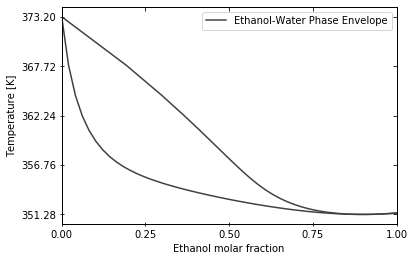

In [68]:
eq = tmo.equilibrium # Thermosteam's equilibrium module
eq.plot_vle_binary_phase_envelope(['Ethanol', 'Water'], P=101325)

Plot the ternary phase diagram of three chemicals in liquid-liquid equilibrium at constant pressure:

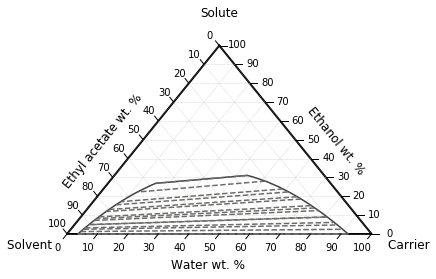

In [69]:
# This one will take like 30 seconds
# Thermosteam's LLE algorithm is stochastic,
# so its much slower than the VLE algorithm.
eq.plot_lle_ternary_diagram('Water', 'Ethanol', 'EthylAcetate', T=298.15)

### Vapor-liquid equilibrium

Vapor-liquid equilibrium can be performed by setting 2 degrees of freedom from the following list: `T` (Temperature; in K), `P` (Pressure; in Pa), `V` (Vapor fraction), and `H` (Enthalpy; in kJ/hr).

For example, set vapor fraction and pressure:

In [70]:
s_eq = tmo.Stream('s_eq', Water=10, Ethanol=10)
s_eq.vle(V=0.5, P=101325)
s_eq.show(composition=True)

MultiStream: s_eq
 phases: ('g', 'l'), T: 353.88 K, P: 101325 Pa
 composition: (g) Water    0.3862
                  Ethanol  0.6138
                  -------  10 kmol/hr
              (l) Water    0.6138
                  Ethanol  0.3862
                  -------  10 kmol/hr


Note that the stream is a now a MultiStream to manage multiple phases. Each phase can be accessed separately too:

In [71]:
s_eq['l'].show()

Stream: 
 phase: 'l', T: 353.88 K, P: 101325 Pa
 flow (kmol/hr): Water    6.14
                 Ethanol  3.86


In [72]:
s_eq['g'].show()

Stream: 
 phase: 'g', T: 353.88 K, P: 101325 Pa
 flow (kmol/hr): Water    3.86
                 Ethanol  6.14


Note that the phase of these substreams cannot be changed:

In [73]:
s_eq['g'].phase = 'l'

AttributeError: phase is locked

Again, the most convinient way to get and set flow rates in is through the `get_flow` and `set_flow` methods:

In [74]:
# Set flow of liquid water
s_eq.set_flow(1, 'gpm', ('l', 'Water'))
s_eq.get_flow('gpm', ('l', 'Water'))

1.0

In [75]:
# Set multiple liquid flows
key = ('l', ('Ethanol', 'Water'))
s_eq.set_flow([10, 20], 'kg/hr', key)
s_eq.get_flow('kg/hr', key)

array([10., 20.])

Chemical flows across all phases can be retrieved if no phase is given:

In [76]:
# Get water and ethanol flows summed across all phases
s_eq.get_flow('kg/hr', ('Water', 'Ethanol'))

array([ 89.567, 292.79 ])

However, setting chemical data of MultiStream objects requires the phase to be specified:

In [77]:
s_eq.set_flow([10, 20], 'kg/hr', ('Water', 'Ethanol'))

IndexError: multiple phases present; must include phase key to set chemical data

Similar to Stream objects, all flow rates can be accessed through the `imol`, `imass`, and `ivol` attributes:

In [78]:
s_eq.imol # Molar flow rates

MolarFlowIndexer (kmol/hr):
 (g) Water     3.862
     Ethanol   6.138
 (l) Water     1.11
     Ethanol   0.2171


In [79]:
# Index a single chemical in the liquid phase
s_eq.imol['l', 'Water']

1.1101687012358397

In [80]:
# Index multiple chemicals in the liquid phase
s_eq.imol['l', ('Ethanol', 'Water')]

array([0.217, 1.11 ])

In [81]:
# Index the vapor phase
s_eq.imol['g']

array([3.862, 6.138, 0.   ])

In [82]:
# Index flow of chemicals summed across all phases
s_eq.imol['Ethanol', 'Water']

array([6.356, 4.972])

Because multiple phases are present, overall chemical flows in MultiStream objects cannot be set like in Stream objects:

In [83]:
s_eq.imol['Ethanol', 'Water'] = [1, 0]

IndexError: multiple phases present; must include phase key to set chemical data

Chemical flows must be set by phase:

In [84]:
s_eq.imol['l', ('Ethanol', 'Water')] = [1, 0]

One main difference between a [MultiStream](../MultiStream.txt) object and a [Stream](../Stream.txt) object is that the `mol` attribute no longer stores any data, it simply returns the total flow rate of each chemical. Setting an element of the array raises an error to prevent the wrong assumption that the data is linked:

In [85]:
s_eq.mol

array([3.862, 7.138, 0.   ])

In [86]:
s_eq.mol[0] = 1

ValueError: assignment destination is read-only

Note that for both Stream and MultiStream objects, `get_flow`, `imol`, and `mol` return chemical flows across all phases when given only chemical IDs.

### Liquid-liquid equilibrium

Liquid-liquid equilibrium (LLE) only requires the temperature. Pressure is not a significant variable as liquid fungacity coefficients are not a strong function of pressure. 

In [87]:
tmo.settings.set_thermo(['Water', 'Butanol', 'Octane'])
liquid_mixture = tmo.Stream('liquid_mixture', Water=100, Octane=100, Butanol=5)
liquid_mixture.lle(T=300)
liquid_mixture

MultiStream: liquid_mixture
 phases: ('L', 'l'), T: 300 K, P: 101325 Pa
 flow (kmol/hr): (L) Water    1.458
                     Butanol  3.791
                     Octane   100
                 (l) Water    98.54
                     Butanol  1.209
                     Octane   0.001977


Compared to VLE, LLE is several orders of magnitude times slower. This is because differential evolution, a purely stochastic method, is used to find the solution that globally minimizes the gibb's free energy of both phases. For now, the LLE algorithm may not present completely accurate results and is subject to change in the future.